In [30]:
import xgboost
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


              precision    recall  f1-score   support

         0.0     0.7965    1.0000    0.8867      9558
         1.0     0.0000    0.0000    0.0000      2442

    accuracy                         0.7965     12000
   macro avg     0.3982    0.5000    0.4434     12000
weighted avg     0.6344    0.7965    0.7063     12000

              precision    recall  f1-score   support

         0.0     0.7967    1.0000    0.8868      2390
         1.0     0.0000    0.0000    0.0000       610

    accuracy                         0.7967      3000
   macro avg     0.3983    0.5000    0.4434      3000
weighted avg     0.6347    0.7967    0.7065      3000



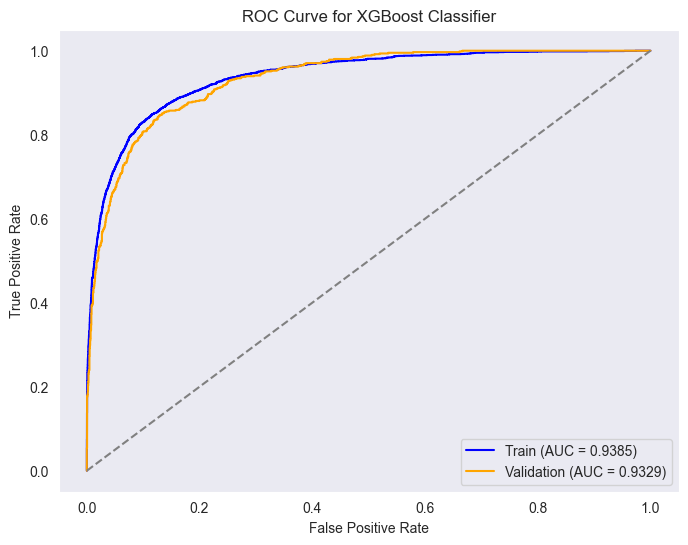

In [37]:

def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    # Drop only if columns exist
    # columns_to_drop = ['CustomerId', 'Surname']
    # df = df.drop(columns=[col for col in columns_to_drop if col in df], axis=1)
    input_cols = list(df.columns)[1:-1]
    target_col = 'Exited'
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

def plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, model, model_name ):
    y_train_probs = model.predict_proba(train_inputs)[:, 1]
    y_val_probs = model.predict_proba(val_inputs)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(train_targets, y_train_probs)
    auc_train = auc(fpr_train, tpr_train)

    fpr_val, tpr_val, _ = roc_curve(val_targets, y_val_probs)
    auc_val = auc(fpr_val, tpr_val)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', color='blue')
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.4f})', color='orange')

    # Plot diagonal reference line (random model)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    # Labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classifier')
    plt.legend(loc='lower right')
    plt.grid()

    # Show plot
    plt.show()

clients_df = pd.read_csv('csv/train.csv')

train_df, val_df = split_train_val(clients_df, 'Exited')

train_inputs, train_targets = separate_inputs_targets(train_df)
val_inputs, val_targets = separate_inputs_targets(val_df)

cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

# # **Step 0: Find Optimal learning_rate**
# xgb = XGBClassifier(
#     objective='binary:logistic',
#     n_estimators=5000,  # Large value to allow early stopping
#     enable_categorical=True,
#     missing=np.nan
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
#     device="cuda"  # Use Metal API on Apple Silicon
# )
#
# param_test0 = {
#     'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001]
# }
#
# gsearch0 = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_test0,
#     scoring='roc_auc',
#     n_jobs=-1,
#     cv=5
# )
#
# gsearch0.fit(train_inputs, train_targets)
#
# best_learning_rate = gsearch0.best_params_['learning_rate']
# print(f"Best Learning Rate: {best_learning_rate}")

best_learning_rate = 0.001

# # **Step 1: Find Optimal n_estimators (Boosting Rounds)**
# xgb = XGBClassifier(
#     learning_rate=best_learning_rate,
#     objective='binary:logistic',
#     enable_categorical=True,
#     missing=np.nan
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
#     device="cuda"  # Use Metal API on Apple Silicon
# )
#
# param_test1 = {'n_estimators': range(1, 100, 1)}
#
# gsearch1 = GridSearchCV(estimator=xgb, param_grid=param_test1, scoring='roc_auc', n_jobs=-1, cv=5)
# gsearch1.fit(train_inputs, train_targets)
#
# best_n_estimators = gsearch1.best_params_['n_estimators']
# print(f"Best n_estimators: {best_n_estimators}")

best_n_estimators = 99

# # **Step 2: Tune max_depth & min_child_weight**
# param_test2 = {
#     'max_depth': range(1, 20, 1),
#     'min_child_weight': range(1, 20, 1)
# }
#
# xgb = XGBClassifier(
#     learning_rate=best_learning_rate,
#     n_estimators=best_n_estimators,
#     objective='binary:logistic',
#     enable_categorical=True,
#     missing=np.nan,
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
# )
#
# gsearch2 = GridSearchCV(estimator=xgb, param_grid=param_test2, scoring='roc_auc', n_jobs=-1, cv=5)
# gsearch2.fit(train_inputs, train_targets)
#
# best_params_depth = gsearch2.best_params_
# print(f"Best max_depth and min_child_weight: {best_params_depth}")

best_params_depth = {
    'max_depth': 6,
    'min_child_weight': 5
}

# # **Step 3: Tune gamma (Regularization Parameter)**
# param_test3 = {'gamma': [i/10.0 for i in range(1, 100)]}
#
# xgb = XGBClassifier(
#     learning_rate=best_learning_rate,
#     n_estimators=best_n_estimators,
#     max_depth=best_params_depth['max_depth'],
#     min_child_weight=best_params_depth['min_child_weight'],
#     objective='binary:logistic',
#     enable_categorical=True,
#     missing=np.nan,
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
# )
#
# gsearch3 = GridSearchCV(estimator=xgb, param_grid=param_test3, scoring='roc_auc', n_jobs=-1, cv=5)
# gsearch3.fit(train_inputs, train_targets)
#
# best_gamma = gsearch3.best_params_['gamma']
# print(f"Best gamma: {best_gamma}")

best_gamma = 0.1

# # **Step 4: Tune `subsample` and `colsample_bytree`**
# param_test4 = {
#     'subsample': [i/10.0 for i in range(1, 100)],
#     'colsample_bytree': [i/10.0 for i in range(1, 100)]
# }
#
# xgb = XGBClassifier(
#     learning_rate=best_learning_rate,
#     n_estimators=best_n_estimators,
#     max_depth=best_params_depth['max_depth'],
#     min_child_weight=best_params_depth['min_child_weight'],
#     gamma=best_gamma,
#     objective='binary:logistic',
#     enable_categorical=True,
#     missing=np.nan,
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
# )
#
# gsearch4 = GridSearchCV(estimator=xgb, param_grid=param_test4, scoring='roc_auc', n_jobs=-1, cv=5)
# gsearch4.fit(train_inputs, train_targets)
#
# best_subsample = gsearch4.best_params_
# print(f"Best subsample and colsample_bytree: {best_subsample}")

best_subsample = {
    'subsample': 0.8,
    'colsample_bytree': 0.4
}

# # **Step 5: Tune Regularization Parameters (`reg_alpha` & `reg_lambda`)**
# param_test5 = {
#     'reg_alpha': np.arange(1, 20, 0.1),
#     'reg_lambda': np.arange(1, 20, 0.1)
# }
#
# xgb = XGBClassifier(
#     learning_rate=best_learning_rate,
#     n_estimators=best_n_estimators,
#     max_depth=best_params_depth['max_depth'],
#     min_child_weight=best_params_depth['min_child_weight'],
#     gamma=best_gamma,
#     subsample=best_subsample['subsample'],
#     colsample_bytree=best_subsample['colsample_bytree'],
#     objective='binary:logistic',
#     enable_categorical=True,
#     missing=np.nan,
#     tree_method="hist",  # GPU-accelerated histogram-based algorithm
# )
#
# gsearch5 = GridSearchCV(estimator=xgb, param_grid=param_test5, scoring='roc_auc', n_jobs=8, cv=5)
# gsearch5.fit(train_inputs, train_targets)
#
# best_regularization = gsearch5.best_params_
# print(f"Best reg_alpha and reg_lambda: {best_regularization}")

best_regularization = {
    'reg_alpha': 1.5000000000000004,
    'reg_lambda': 1.3000000000000003
}

# **Step 6: Final Model with Reduced Learning Rate**
final_xgb = XGBClassifier(
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators * 5,  # Increase number of estimators
    max_depth=best_params_depth['max_depth'],
    min_child_weight=best_params_depth['min_child_weight'],
    gamma=best_gamma,
    subsample=best_subsample['subsample'],
    colsample_bytree=best_subsample['colsample_bytree'],
    reg_alpha=best_regularization['reg_alpha'],
    reg_lambda=best_regularization['reg_lambda'],
    objective='binary:logistic',
    enable_categorical=True,
    missing=np.nan,
    tree_method="hist",  # GPU-accelerated histogram-based algorithm
)

final_xgb.fit(train_inputs, train_targets)


# **Evaluate Final Model**
train_pred = final_xgb.predict(train_inputs)
val_pred = final_xgb.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

# **Plot ROC Curve**
plot_roc_curve(train_inputs, train_targets, val_inputs, val_targets, final_xgb, 'XGBoost')

In [38]:
clients_df_test = pd.read_csv('csv/test.csv')

columns_to_drop = ['id', 'Exited']
clients_df_test.drop(columns=[col for col in columns_to_drop if col in clients_df_test.columns], axis=1, inplace=True)
cat_features = clients_df_test.select_dtypes(include='object').columns
clients_df_test[cat_features] = clients_df_test[cat_features].astype('category')

test_xgb_clf_clf = final_xgb.predict_proba(clients_df_test)[:,1]
clients_df_test['Exited'] = test_xgb_clf_clf
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_test_xgb_clf_clf.csv', index=False)

